# IRIS Classification on Lava

**IRIS** is a toy dataset that will be used to primarily explore the **LAVA** programming workflow. In particular, we will be using *lava-dl*, which is built on top of *slayer* with a few extra features.

In [1]:
import os, sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer

import IPython.display as display
from matplotlib import animation

## Create Dataset

Dataset overview: The dataset consists of 4 attributes, namely: sepal length/width and petal length/width. There are 3 classes of Iris flowers: Setosas, Versicolour, and Virginica. Note, one class is linearly separable from the other 2 (Setosa against Versicolour/Virginica); the latter are not sepearable from each other. Although each class is evenly distributed, linear separability in one class poses an issue of model accuracy. In other words, we will be able to predict the class Setosa, while having more difficulty separating the other two classes using accuracy during earlier epochs of training. Thus, we assess the quality of the model using **F1 score** (a test validating this is conducted below).

In [2]:
!pip install pandas
import pandas as pd

class IrisDataset(Dataset):
    def __init__(self, data_file, label_file, transform=None, target_transform=None, time_steps=8):
        features = pd.read_csv(data_file, header=None).values
        labels = pd.read_csv(label_file, header=None).values
        
        self.X = torch.tensor(features).type(torch.FloatTensor)
        self.X = self.X.reshape(150, 4, 1).repeat(1, 1, time_steps)
        self.y = torch.tensor(labels).squeeze(1)
    
        print(self.X.shape)
        print(self.y.shape)
        
        self.samples = features.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
        
    def __len__(self):
        return self.samples
        
dataset = IrisDataset('data/iris_data.csv', 'data/iris_label.csv')
dataset[100]
# len(dataset)

torch.Size([150, 4, 8])
torch.Size([150])


(tensor([[6.3000, 6.3000, 6.3000, 6.3000, 6.3000, 6.3000, 6.3000, 6.3000],
         [3.3000, 3.3000, 3.3000, 3.3000, 3.3000, 3.3000, 3.3000, 3.3000],
         [6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000, 6.0000],
         [2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000]]),
 tensor(2))

## Create Network

In [3]:
# !pip install torchsummary
from torchvision import models
from torchsummary import summary

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 1.75,
                'current_decay' : 0.25 , # this must be 1 to use batchnorm
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : False,
            }
        
        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params, 4, 24, weight_norm=True),
#                 slayer.block.cuba.Dense(neuron_params, 24, 24, weight_norm=True),
                slayer.block.cuba.Dense(neuron_params, 24, 3, weight_norm=True),
            ])

    def forward(self, x):
        # Assume the tensor is in format NCT        
        for block in self.blocks:
            x = block(x)
#             print(block.neuron.voltage_state)

#         print(self.blocks[1].neuron.voltage_state)
        return x

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        
        for i, b in enumerate(self.blocks):
            print(b.shape)
            b.export_hdf5(layer.create_group(f'{i}'))
        h.close()
            
# Setup device and test network
# device = torch.device('cpu')
device = torch.device('cuda') 

net = Network().to(device)
summary(net, (4,1,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
             Dense-1          [-1, 24, 1, 1, 1]              96
            Neuron-2          [-1, 24, 1, 1, 1]               0
             Dense-3          [-1, 24, 1, 1, 1]               0
             Dense-4           [-1, 3, 1, 1, 1]              72
            Neuron-5           [-1, 3, 1, 1, 1]               0
             Dense-6           [-1, 3, 1, 1, 1]               0
Total params: 168
Trainable params: 168
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## Instantiate Network, Optimizer, DataSet, and DataLoader

The data is randomly split using the *SubsetRandomSampler* via a specified test_split, shuffle_dataset, and random_seed parameters. These are then used to create a consumable dataloader with a specified batch_size.

The network is run on a GPU 'cuda' device via `torch.device('cuda')`.

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

# Setup dataset
batch_size = 16
test_split = 0.2
shuffle_dataset = True
random_seed = 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split*dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, test_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
# train_sampler = SequentialSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Setup dataloader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

# Setup network device
# device = torch.device('cpu')
device = torch.device('cuda') 

# Instantiate network and optimizer
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [5]:
# print(net)
# print(dir(net.blocks[1].neuron))
# print(type(net.blocks[0].synapse))
# print(net.blocks[1].neuron.state_dict())

## Visualize the input data

Note, for actual training purposes each input is fed in as a signal duplicated over timesteps *t* specified in the Network class.

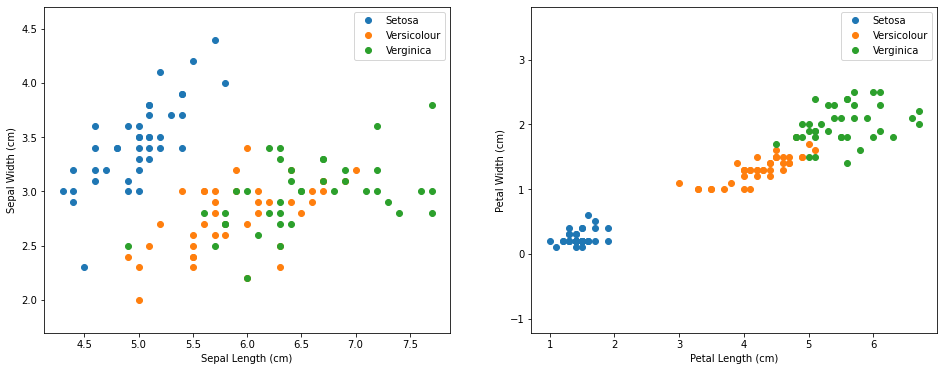

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
target_name = ['Setosa', 'Versicolour', 'Verginica']
plot_X = {}

for name in target_name:
    plot_X[name] = []

for data in train_loader:
    batch_X, batch_y = data
    for i, x in enumerate(batch_X):
        plot_X[target_name[batch_y[i]]].append(x)
    
for name in target_name:       
    # Extract sepal length and width
    sl = [x.squeeze()[0][0] for x in plot_X[name]]
    sw = [x.squeeze()[1][0] for x in plot_X[name]]
    
    # Extract petal length and width
    pl = [x.squeeze()[2][0] for x in plot_X[name]]
    pw = [x.squeeze()[3][0] for x in plot_X[name]]

    ax1.plot(sl, sw, linestyle='none',
                marker='o',
                label=name)
    
    ax2.plot(pl, pw, linestyle='none',
                marker='o',
                label=name)

ax1.set_xlabel('Sepal Length (cm)')
ax1.set_ylabel('Sepal Width (cm)')
ax1.axis('equal')
ax1.legend()

ax2.set_xlabel('Petal Length (cm)')
ax2.set_ylabel('Petal Width (cm)')
ax2.axis('equal')
ax2.legend()

plt.show()

## Error, Stats, and Assistants

We utilize `SpikeRate` loss and target high spiking rate for true class and low spiking rate for false class. `LearningStats` is a logger for training, validation, and testing. Finally, the `Assistant` wraps common training and testing routing which helps simplify the training routine.

In [7]:
# error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device)
error = slayer.loss.SpikeMax(mode='softmax').to(device)
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

## Training Loop
This loop mainly consists of looping over epochs and calling `assistant.train` and `assistant.test` utilities over training and testing dataset. The `assistant` utility takes care of standard backpropagation procedure internally.

* `stats` can be used in print statement to get formatted stats printout.
* `stats.testing.best_loss` can be used to find out if the current iteration has the best testing loss. Here, we use it to save the best model.
* `stats.update()` updates the stats collected for the epoch.
* `stats.save` saves the stats in files.

In [8]:
epochs = 500

for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader): # training loop
        output = assistant.train(input, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
#     print(net.blocks[1].neuron.state_dict())
        
    for i, (input, label) in enumerate(test_loader): # testing loop
        output = assistant.test(input, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    if epoch%20 == 19: # cleanup display
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        stats_str = str(stats).replace("| ", "\n")
        print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')
    
    if stats.testing.best_accuracy:
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
#     net.grad_flow(trained_folder + '/')

                                                                                                                                                                                        
[Epoch 19/500]
Train loss =    16.74396 (min =    16.76511)    accuracy = 0.32500 (max = 0.32500) 
Test  loss =    16.17233 (min =    16.03196)    accuracy = 0.36667 (max = 0.36667)
                                                                                                                                                                                        
[Epoch 39/500]
Train loss =    16.47763 (min =    16.49807)    accuracy = 0.32500 (max = 0.32500) 
Test  loss =    15.91935 (min =    15.90021)    accuracy = 0.36667 (max = 0.36667)
                                                                                                                                                                                        
[Epoch 59/500]
Train loss =    16.29633 (min =    16.29560)    accuracy = 0.32500

## Learning plots

Plots the learning curves

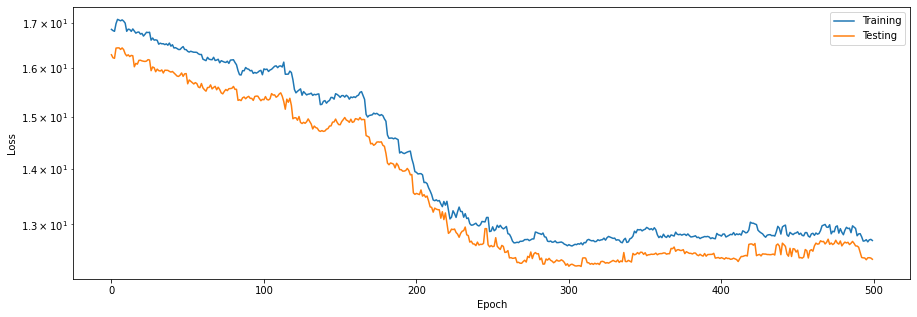

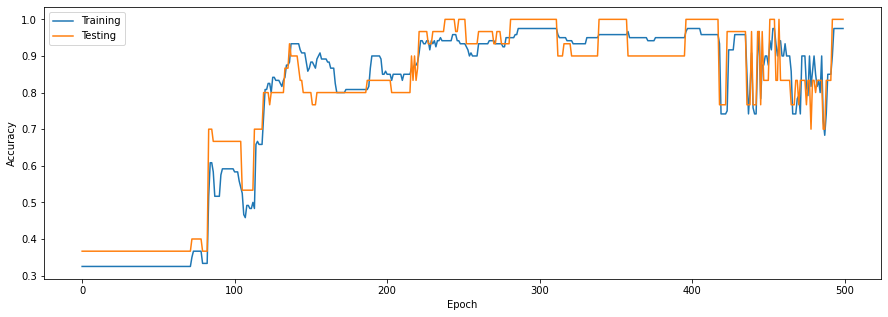

In [9]:
stats.plot(figsize=(15, 5))

## Export the best trained model

Load the best model during training and export it as hdf5 network. It is supported by `lava.lib.dl.netx` to automatically load the network as a lava process.

In [15]:
net = Network().to(device)
net_pt = torch.load(trained_folder + '/network.pt')
summary(net, (4,1)) # network has to be dummy initialized before load_state
net.load_state_dict(net_pt)
net.export_hdf5(trained_folder + '/network.net')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
             Dense-1                [-1, 24, 1]              96
            Neuron-2                [-1, 24, 1]               0
             Dense-3                [-1, 24, 1]               0
             Dense-4                 [-1, 3, 1]              72
            Neuron-5                 [-1, 3, 1]               0
             Dense-6                 [-1, 3, 1]               0
Total params: 168
Trainable params: 168
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
torch.Size([24])
torch.Size([3])


In [16]:
error = slayer.loss.SpikeMax(mode='softmax').to(device)
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

for epoch in range(1):
    for i, (input, label) in enumerate(test_loader): # test set
        output = assistant.test(input, label)
    print(f'\r[Epoch {epoch:2d}/{1}] {stats}')
    print('Correct samples (test): ',stats.testing.correct_samples,'/',stats.testing.num_samples)
    
for epoch in range(1):
    for i, (input, label) in enumerate(train_loader): # train set
        output = assistant.test(input, label)
    print(f'\r[Epoch {epoch:2d}/{1}] {stats}')
    print('Correct samples (train): ',stats.testing.correct_samples,'/',stats.testing.num_samples)

[Epoch  0/1] Train  | Test  loss =    12.64413                        accuracy = 1.00000
Correct samples (test):  30 / 30
[Epoch  0/1] Train  | Test  loss =    12.91178                        accuracy = 0.95333
Correct samples (train):  143 / 150


In [12]:
# error = slayer.loss.SpikeMax(mode='softmax').to(device)
# stats = slayer.utils.LearningStats()
# assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

# full_loader = torch.utils.data.DataLoader(dataset)
# for epoch in range(1):
#     for i, (input, label) in enumerate(test_loader): # full unscrambled set
#         output = assistant.test(input, label)
#         print(output, label)
#         break
#     print(f'\r[Epoch {epoch:2d}/{1}] {stats}')
#     print('Correct samples (test): ',stats.testing.correct_samples,'/',stats.testing.num_samples)

## Visualize the network output

Here, we will use `slayer.io.tensor_to_event` method to conver the torch output spike tensor into graded (non-binary) `slayer.io.Event` object and visualize a few input and output event pairs.

In [13]:
for i in range(3):
    out_event = slayer.io.tensor_to_event(output[i].cpu().data.numpy().reshape(1,3,-1))
    out_anim = out_event.anim(fig=plt.figure(figsize=(10,6)), frame_rate=2400, pre_compute_frames=True)
    out_anim.save(f'gifs/out{i}.gif', animation.PillowWriter(fps=24), dpi=300)

----------- Class: 2 -----------


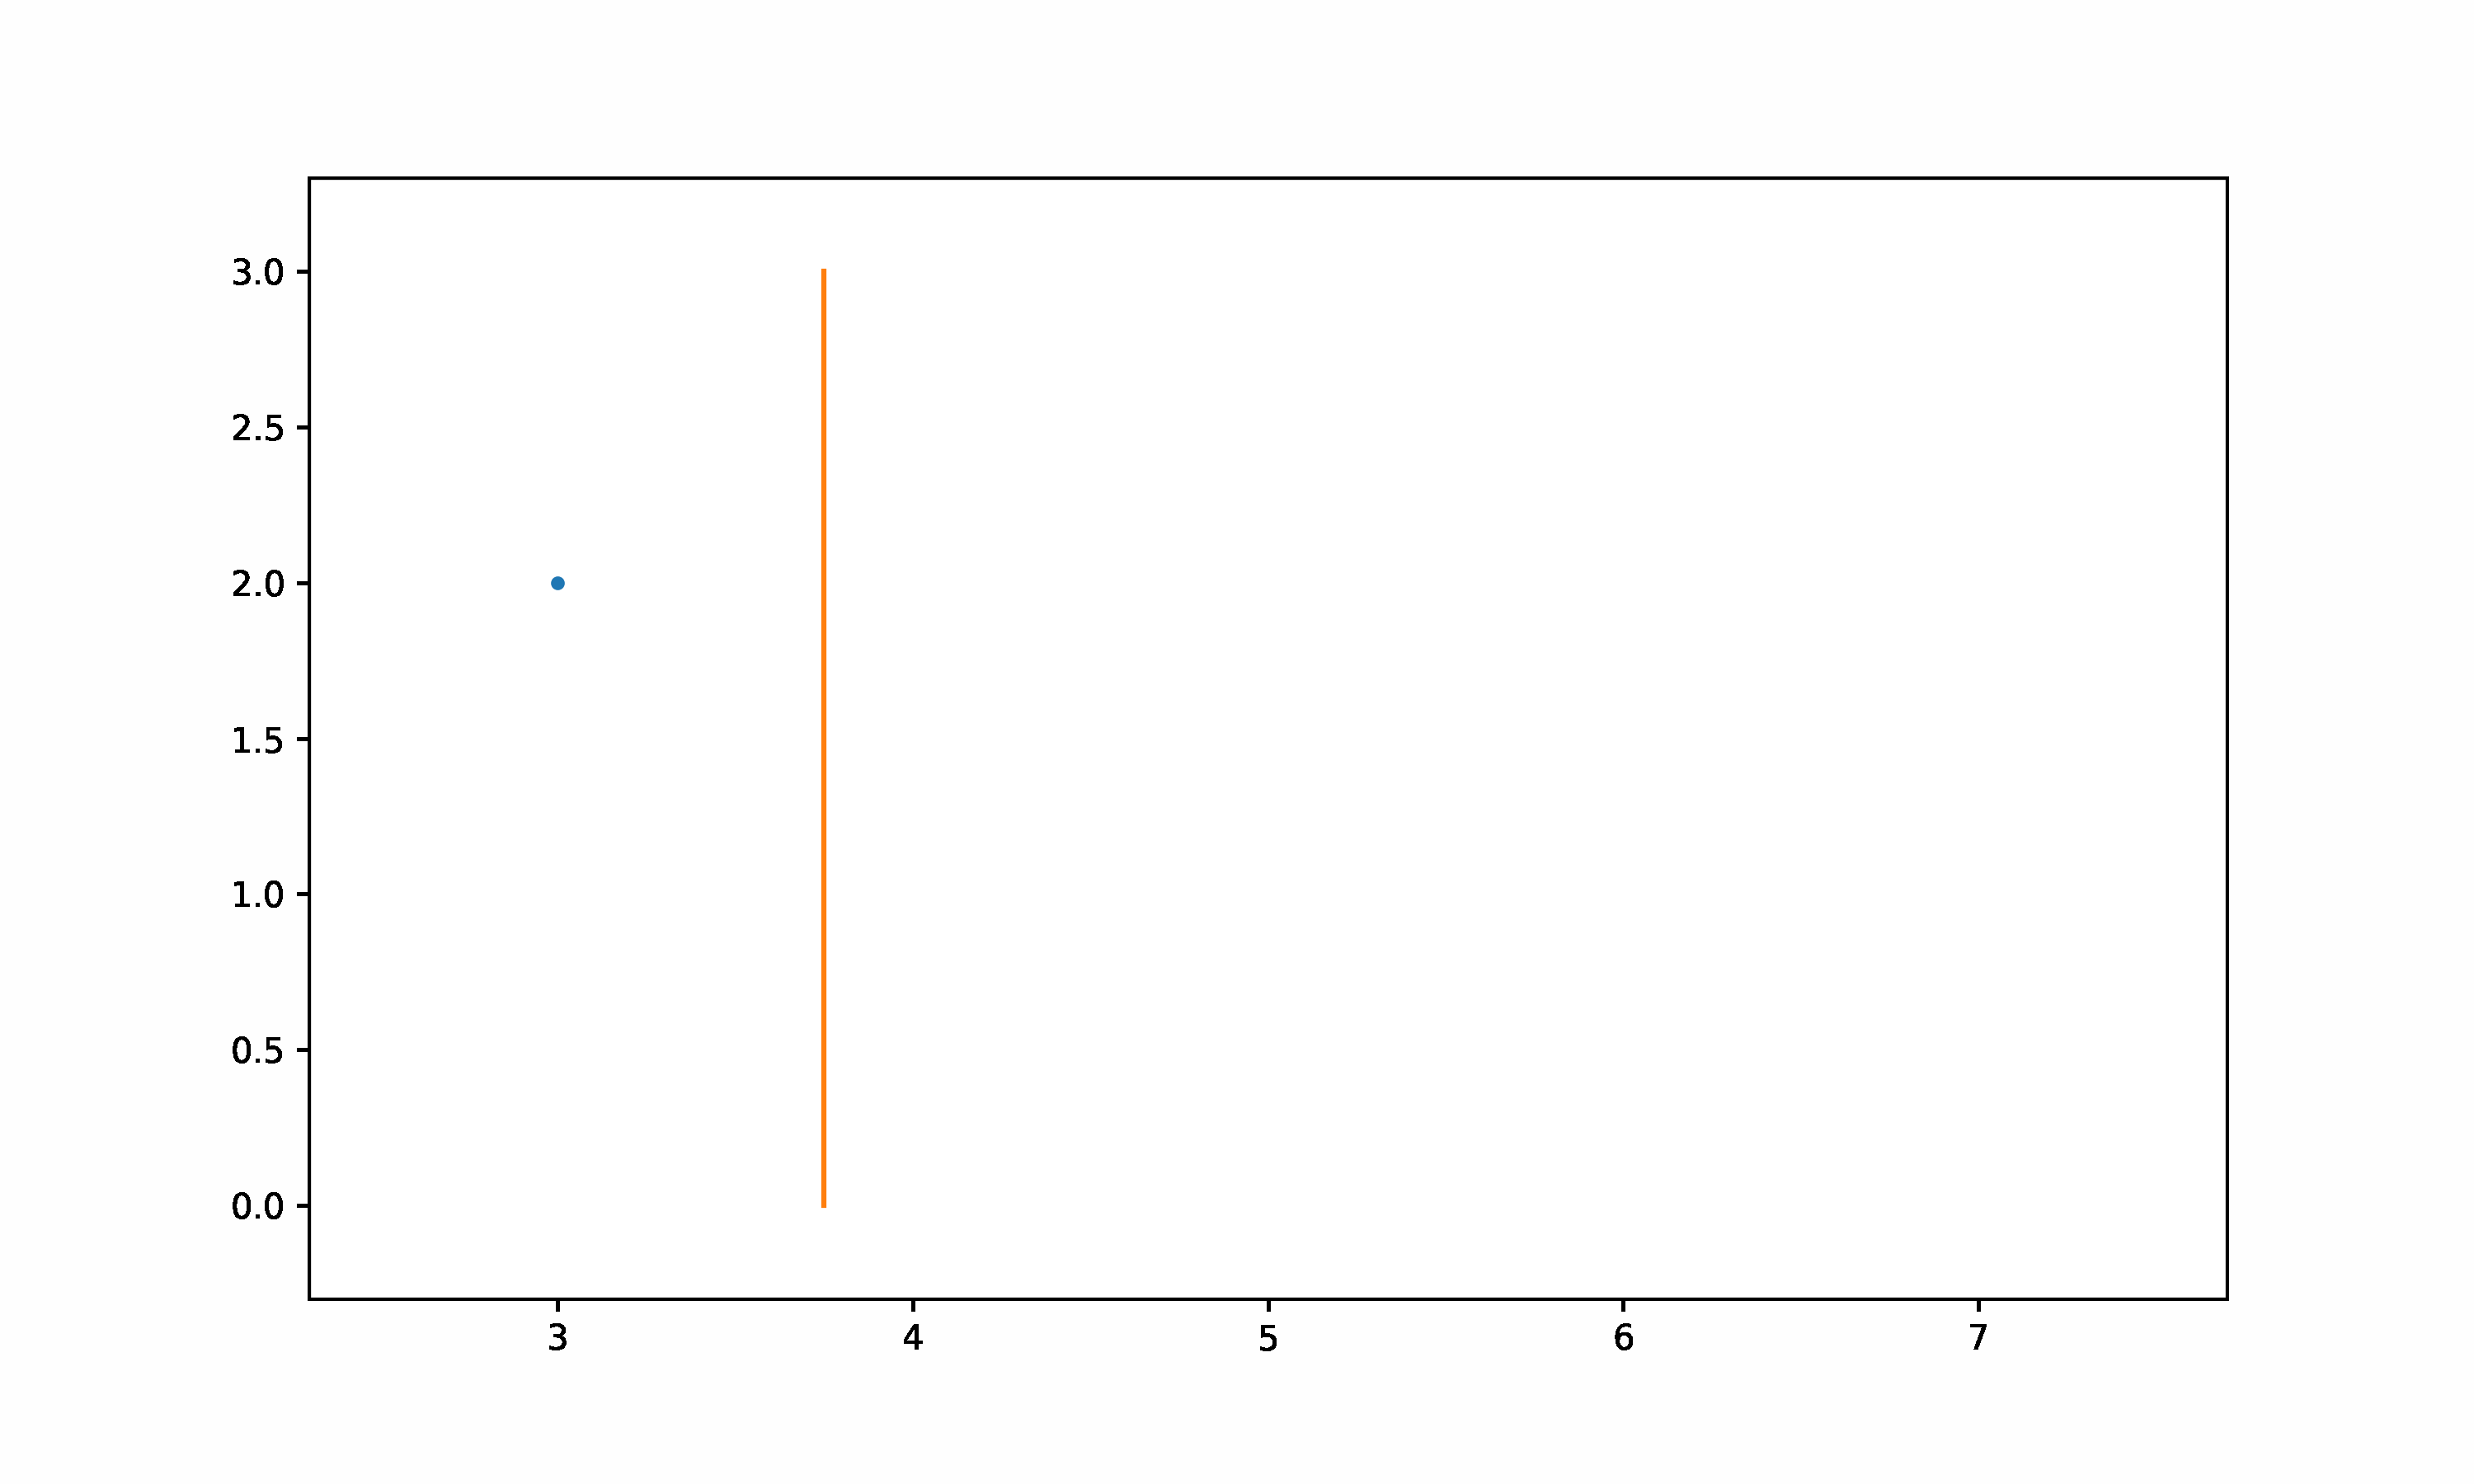

----------- Class: 2 -----------


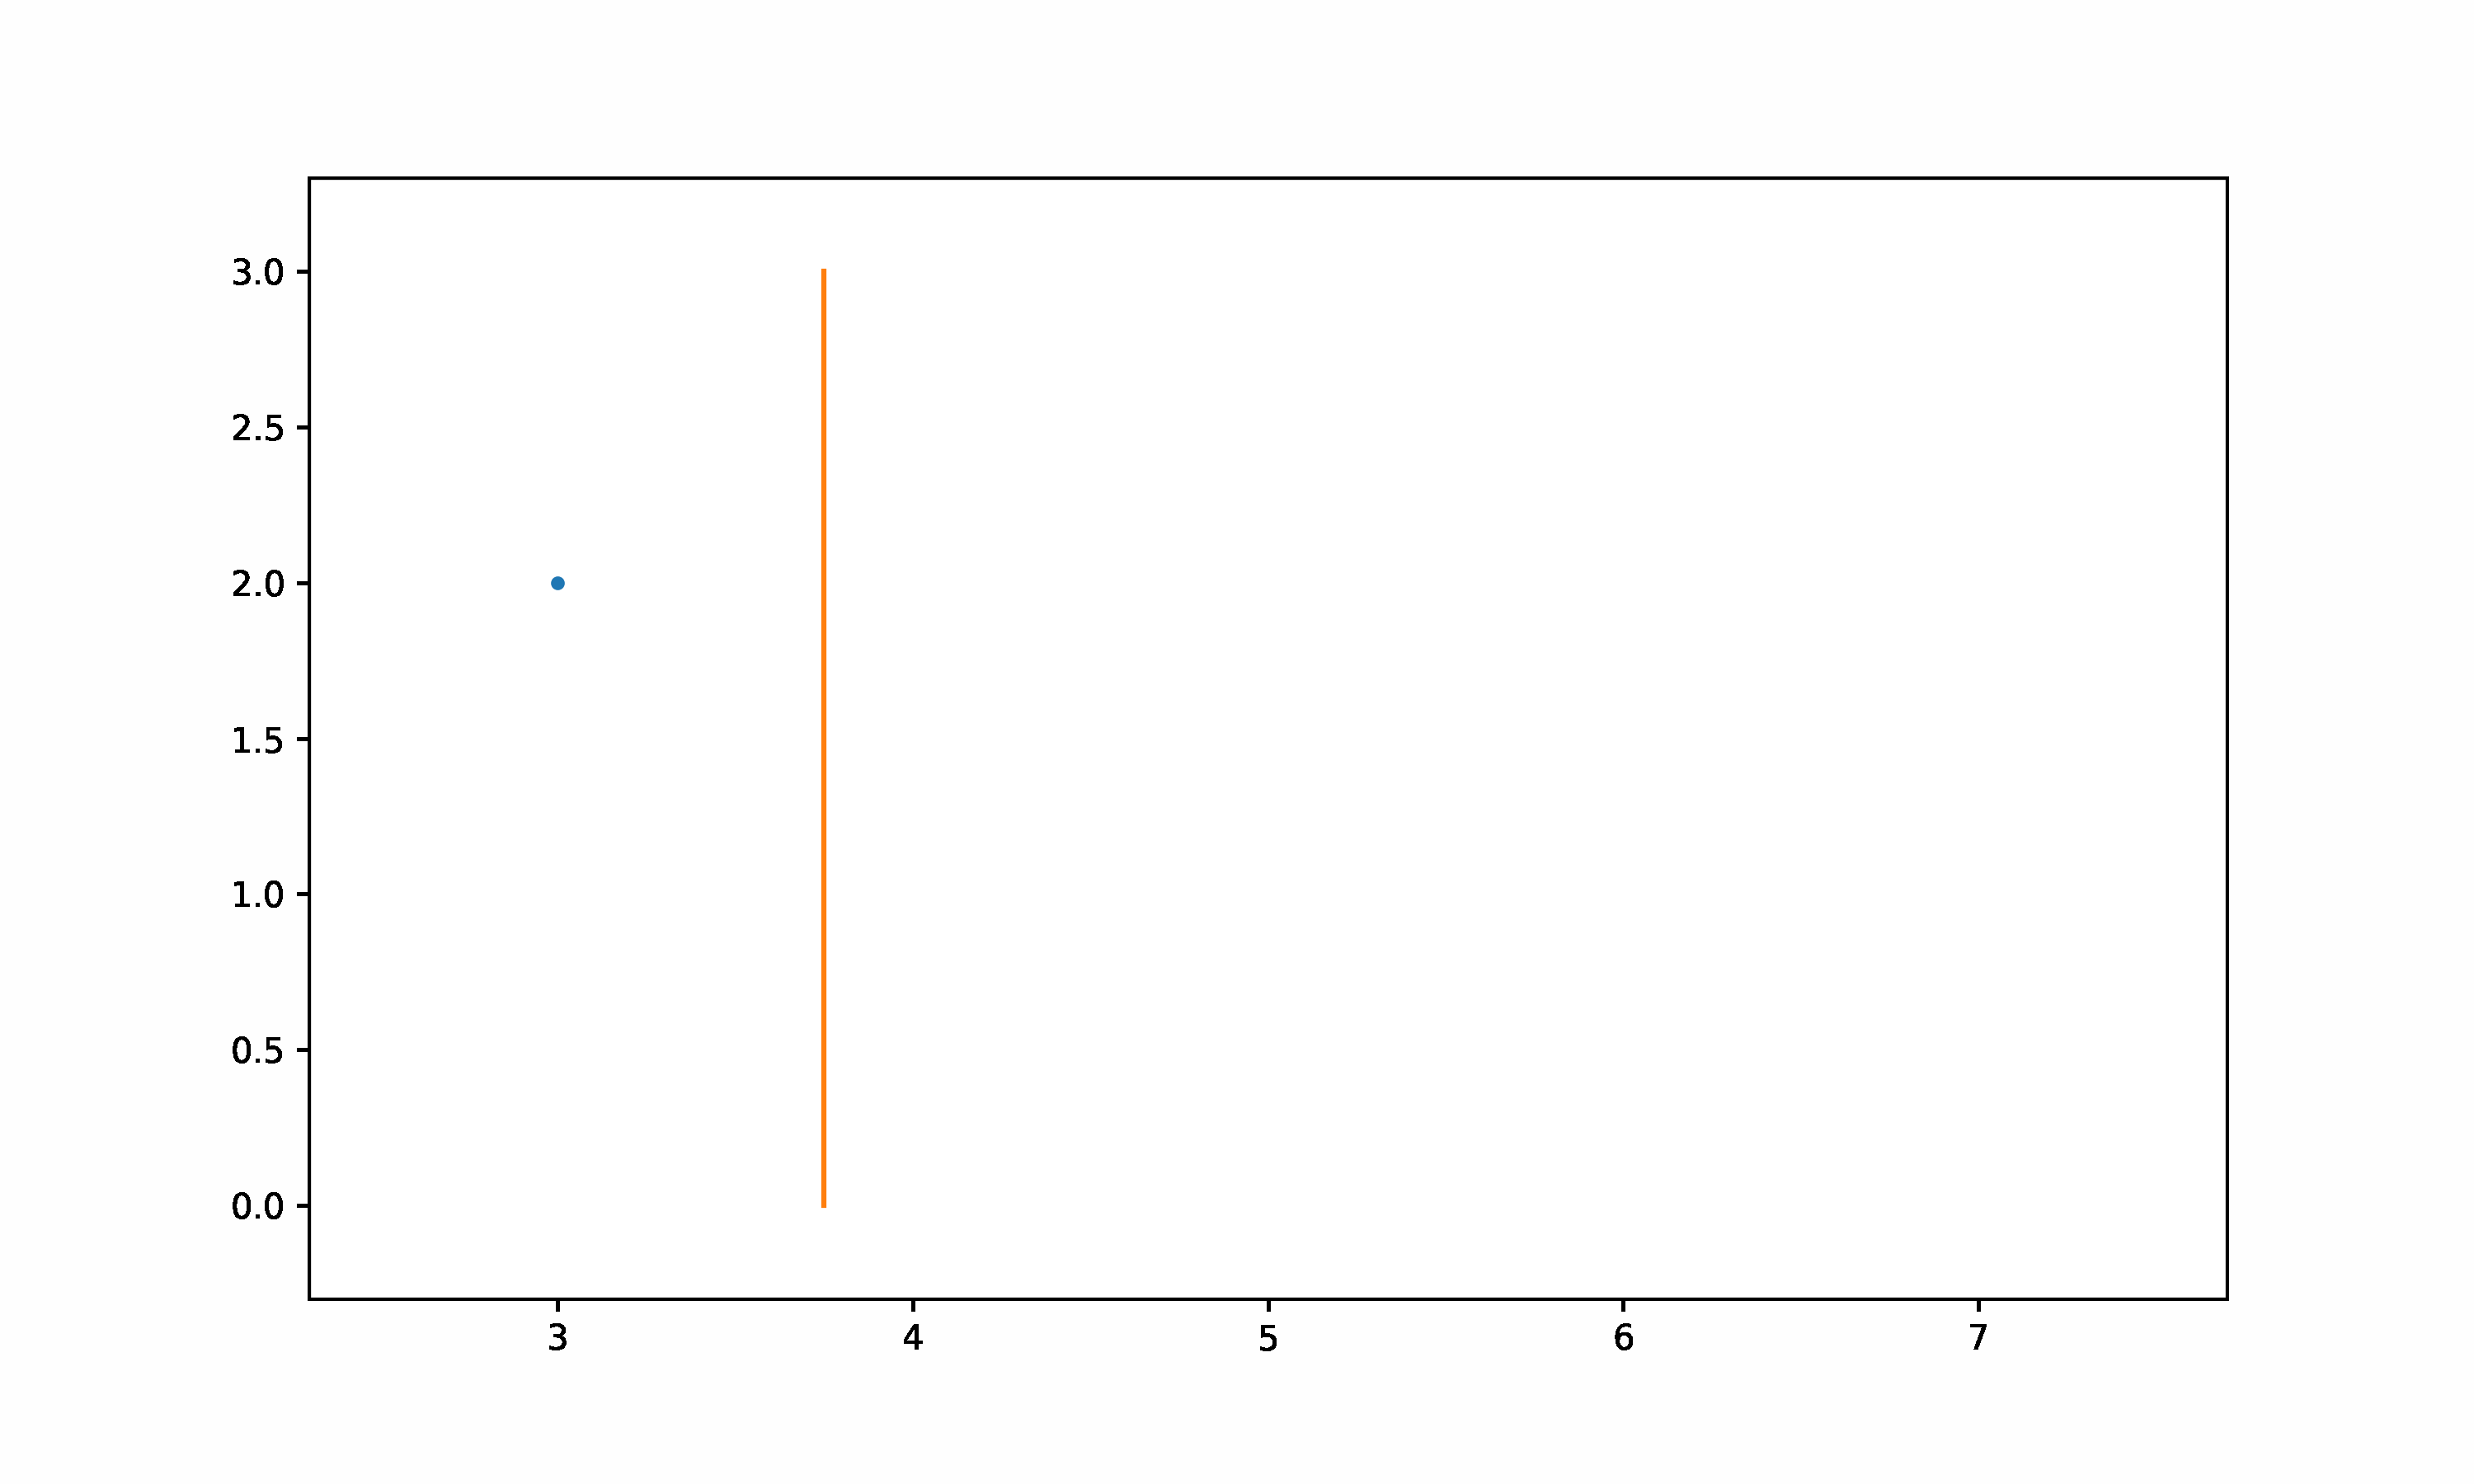

----------- Class: 1 -----------


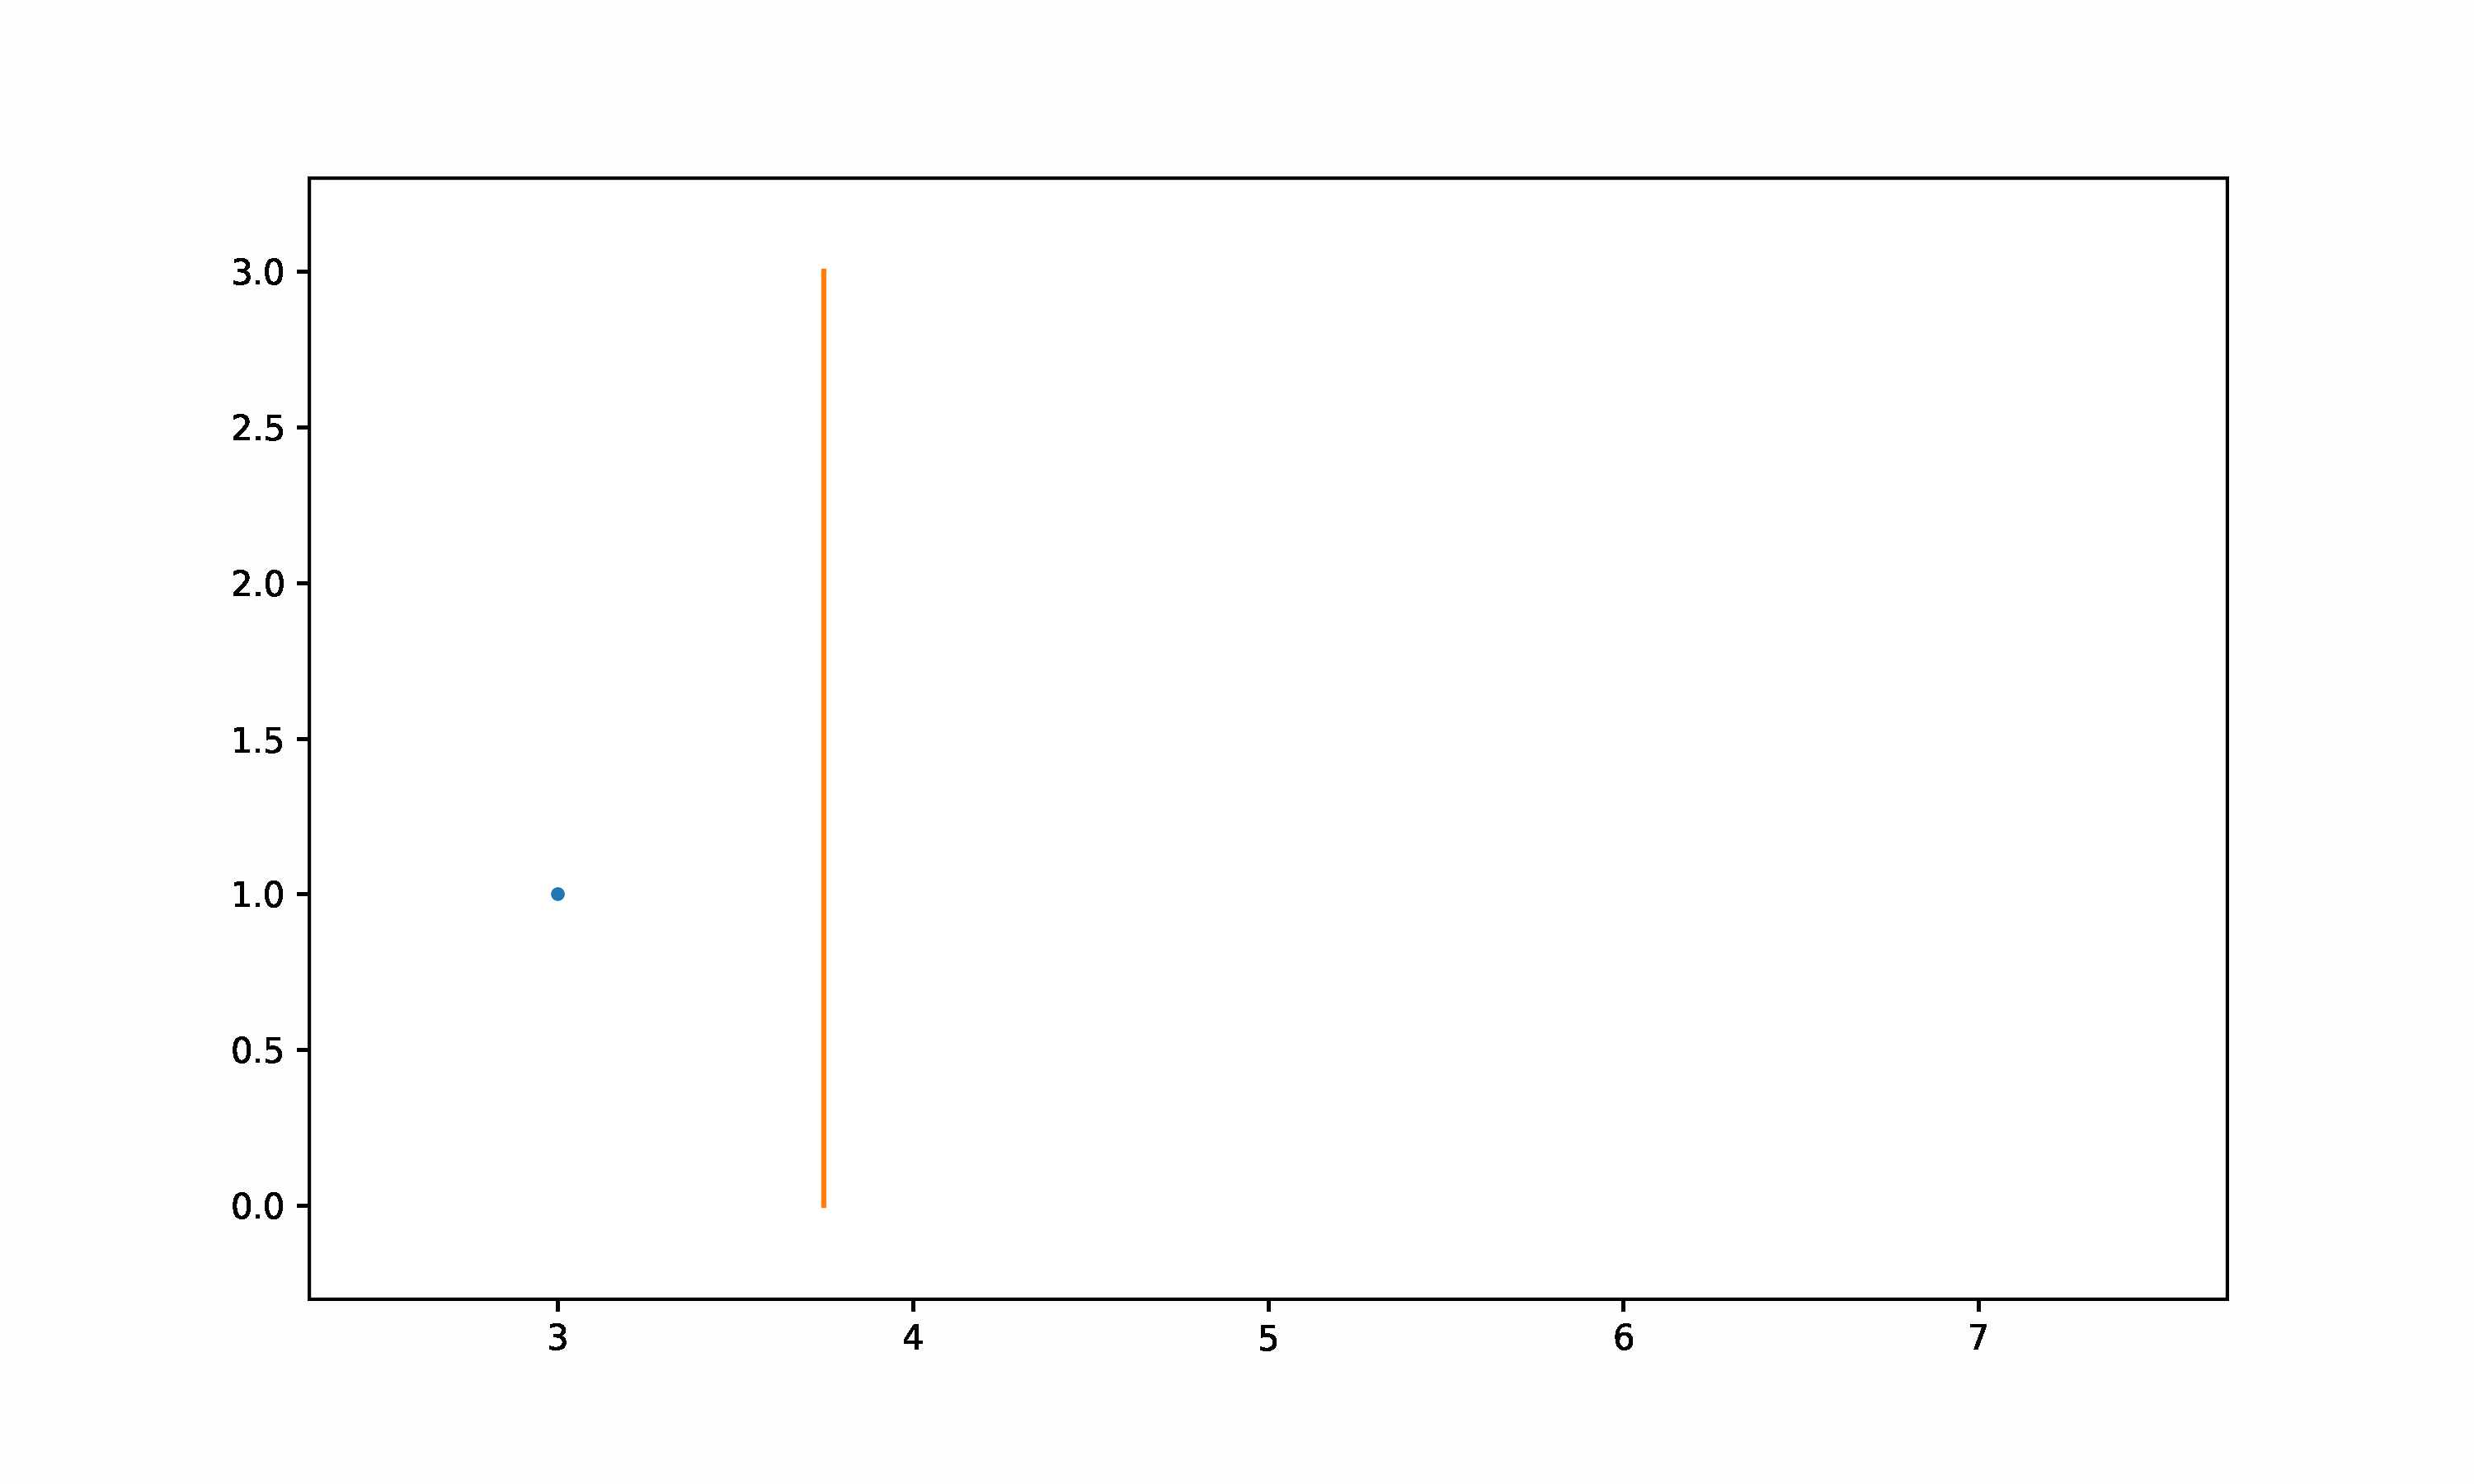

In [14]:
from IPython.display import display, Image

for i in range(3):
    with open(f'gifs/out{i}.gif','rb') as f:
        print('----------- Class:', str(label[i].numpy()), '-----------')
        display(Image(data=f.read(), format='gif', width='600', height='150'))